In [1]:
%reset
#NEW SCRIPT
import subprocess, psutil, time, json, pandas, math, numpy, threading
import matplotlib.pyplot as plt
#import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import ScalarFormatter
matplotlib.rcParams.update({'font.size': 25})
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

# Memory / Time
This section runs with "full_simulations" data. The circuit and the run number must be selected 

##### 

In [8]:
circuit = 'HTTP_Merkle'
run = 6
path = "outputs/full_simulations/"+circuit+"/run"+str(run)
print(path)

outputs/full_simulations/HTTP_Merkle/run6


### Setup

1135952732.0


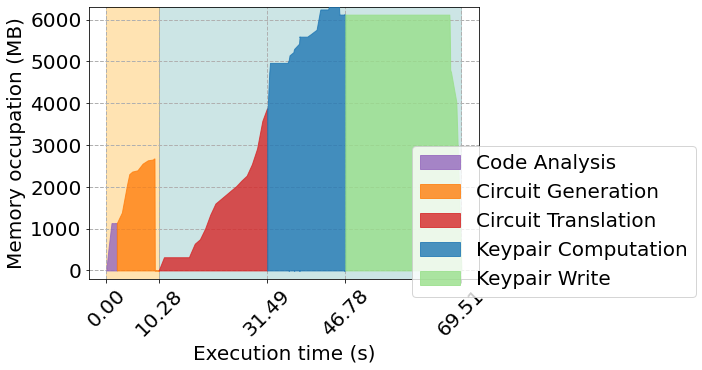

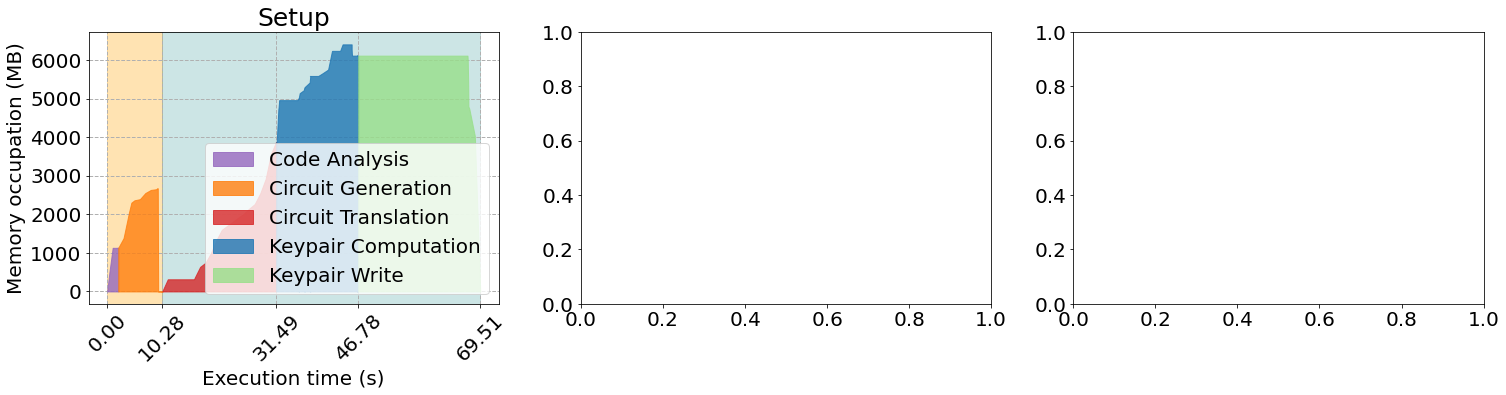

([<matplotlib.axis.XTick at 0x7f934502bac0>,
 [Text(0.0, 0, '0.00'),
  Text(69.51, 0, '69.51'),
  Text(10.28, 0, '10.28'),
  Text(31.49, 0, '31.49'),
  Text(46.78, 0, '46.78')])

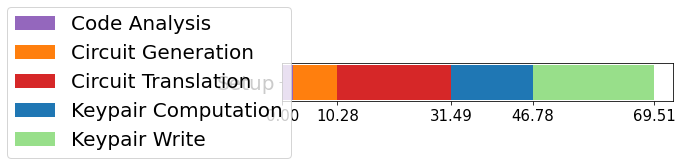

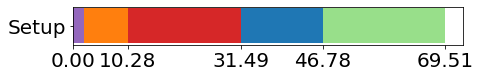

In [9]:
#Data manipulation

#circuit = 'HTTP_String'
df_temp = pandas.read_json(path+"/setup_"+circuit+"_output.json").round(2)
pk_size=df_temp.tail(2).values[0][1]
print(pk_size)
df_temp = df_temp[:-2]
df_temp.columns = ['output', 'timestamp', 'cpu_timestamp']
timestamps=df_temp['timestamp']
df_temp = df_temp.iloc[:, [1,2,0]]
df_temp.set_index('timestamp')

df = pandas.read_json(path+"/setup_"+circuit+"_memory.json").round(2)
df.columns = ['memory', 'timestamp', 'cpu_timestamp']
df = df.iloc[:, [1,2,0]]
df.set_index('timestamp')
#df_temp['timestamp'].add(last_time)
#df=df.append(df_temp,ignore_index=True)

labels = ["Code Analysis", "Circuit Generation", "Circuit Translation", "Keypair Computation", "Keypair Write", "VK Write"]
df.set_index('timestamp') 
df_temp.set_index('timestamp')
df = df.merge(df_temp, how = 'outer')
df['memory'] = df['memory'].fillna(value=0)
df['timestamp'] = df['timestamp']-df['timestamp'].iloc[0]
#print(df.to_string())

timestamps=df_temp['timestamp']
#print(timestamps)
highlights = [0,#timestamps[df_temp['output'].str.contains('\[1st Phase\]')].values[0], 
	      	timestamps[df_temp['output'].str.contains('\[2nd Phase\]')].values[0], 
			timestamps[df_temp['output'].str.contains('Reset time counters for profiling')].values[0],
			timestamps[df_temp['output'].str.contains('Example created!')].values[0],
			timestamps[df_temp['output'].str.contains('Writing prover key to file...')].values[0], 
			timestamps.tail(1).values[0]]
#print(highlights)



#Memory occupation plots
fig, ax=plt.subplots(figsize=(7,5))

#Single plot-----------------------
plt.ylim([-200, 6300])
#print(plt.style.available)
#plt.style.use('fivethirtyeight')
plt.plot(df['timestamp'], df['memory'], linewidth=0, zorder=3)

#print(df['timestamp'] in highlights)
#print(df[df['timestamp'] in highlights].to_string())

ticks=[highlights[0], highlights[-1]]
thr = 7
for tick in highlights:
	if not any(abs(tick - num) <= thr for num in ticks):
		ticks.append(tick)
plt.xlabel("Execution time (s)")
plt.ylabel("Memory occupation (MB)")
plt.yticks(numpy.arange(0, 7000, step=1000))
plt.xticks(ticks, rotation = 45)
colorlist = ['C8', 'C2', 'C6', 'C0', 'C5']
for (i,instant) in enumerate(highlights[:-1]):
	index = df['timestamp'].between(highlights[i], highlights[i+1], inclusive="both")
	plt.fill_between(df['timestamp'][index], df['memory'][index], label=labels[i], alpha=0.8, zorder=4+i, color=colorlist[i])
plt.legend(loc='center right', bbox_to_anchor=(1.58, 0.21)).set_zorder(100)
plt.grid(linestyle = '--', linewidth = 1, zorder=2)
plt.axvspan(0, highlights[2], color='orange', alpha=0.3, zorder=1)
plt.axvspan(highlights[2], highlights[-1], color='teal', alpha=0.2, zorder=1)
#plt.title("Setup", fontsize=25)
#plt.savefig("stringsetupmemlegend2.pdf", format="pdf", bbox_inches="tight")
plt.show()
#End single plot-----------------

#Subplots-------------------------
fig2, ax2 = plt.subplots(1,3,figsize=(25, 5))
plt.sca(ax2[0])
plt.plot(df['timestamp'], df['memory'], linewidth=0, zorder=3)

ticks=[highlights[0], highlights[-1]]
thr = 7
for tick in highlights:
	if not any(abs(tick - num) <= thr for num in ticks):
		ticks.append(tick)
plt.xlabel("Execution time (s)")
plt.ylabel("Memory occupation (MB)")
plt.yticks(numpy.arange(0, 7000, step=1000))
plt.xticks(ticks, rotation = 45)
colorlist = ['C8', 'C2', 'C6', 'C0', 'C5']
for (i,instant) in enumerate(highlights[:-1]):
	index = df['timestamp'].between(highlights[i], highlights[i+1], inclusive="both")
	plt.fill_between(df['timestamp'][index], df['memory'][index], label=labels[i], alpha=0.8, zorder=4+i, color=colorlist[i])
plt.legend().set_zorder(100)
plt.grid(linestyle = '--', linewidth = 1, zorder=2)
plt.axvspan(0, highlights[2], color='orange', alpha=0.3, zorder=1)
plt.axvspan(highlights[2], highlights[-1], color='teal', alpha=0.2, zorder=1)
plt.title("Setup", fontsize=25)
#plt.savefig("stringsetupmemlegend2.pdf", format="pdf", bbox_inches="tight")
plt.show()

#END MEMORY-----------------------

#BAR CHARTS-------------------------
plt.figure(figsize=(7, 0.7))
for (i, instant) in enumerate(highlights[:-1]):
	plt.barh("Setup", highlights[i+1]-highlights[i], height=0.3, left = (highlights[i]), label=labels[i], color=colorlist[i])
plt.legend(loc='center left', bbox_to_anchor=(-0.73, 0.5))
plt.xticks(ticks, rotation=0, fontsize=15)
#plt.savefig("stringsetupbarlegend.pdf", format="pdf", bbox_inches="tight")
#plt.show()

plt.figure(figsize=(7, 0.7))
for (i, instant) in enumerate(highlights[:-1]):
    plt.barh("Setup", highlights[i+1]-highlights[i], height=0.3, left = (highlights[i]), label=labels[i], color=colorlist[i])
plt.xticks(ticks, rotation=0)


##END SETUP###


### Prove

0       0.000000
1       9.087622
2       9.098892
3       9.776352
4       9.805812
         ...    
405    59.313182
406    59.349212
407    59.384962
408    59.430372
409    61.068792
Name: timestamp, Length: 410, dtype: float64
9.087621856
     timestamp      memory  cpu_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

/tmp/ipykernel_9098/2005962130.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['timestamp'][0] = 0


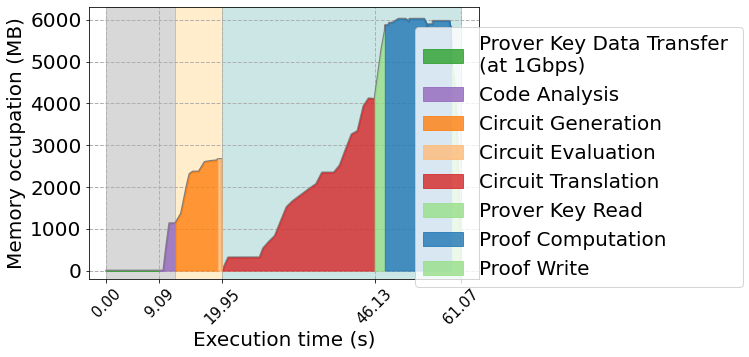

/tmp/ipykernel_9098/2005962130.py:117: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_bar.show()


([<matplotlib.axis.XTick at 0x7f9344f937c0>,
 [Text(0.0, 0, '0.00'),
  Text(61.068791856, 0, '61.07'),
  Text(19.946551856, 0, '19.95'),
  Text(9.087621856, 0, '9.09'),
  Text(46.130881855999995, 0, '46.13')])

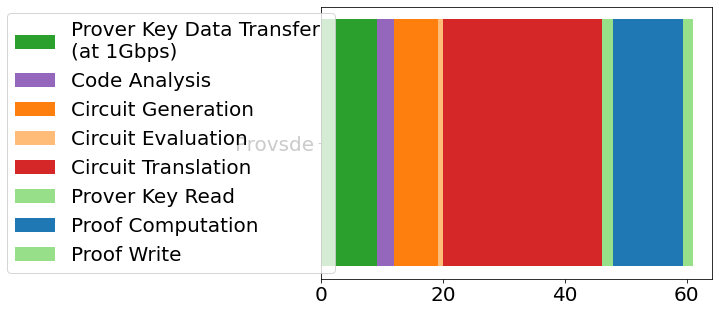

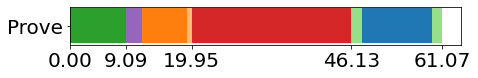

In [10]:
max_memory = []
exec_time = []
transfer_time = (pk_size*8)/1000000000

###PROVE###
###SETUP PLOT###
df2 = pandas.read_json(path+"/prove_"+circuit+"_output.json").round(5)
df2.columns = ['output', 'timestamp', 'cpu_timestamp']
old_duration = df2['timestamp'][1]
df2['timestamp'] = df2['timestamp'] - old_duration + transfer_time
df2['timestamp'][0] = 0
timestamps=df2['timestamp']
print(timestamps)
df2 = df2.iloc[:, [1,0, 2]]
df2.set_index('timestamp')

df = pandas.read_json(path+"/prove_"+circuit+"_memory.json").round(5)
df.columns = ['memory', 'timestamp', 'cpu_timestamp']
df['timestamp'] = df['timestamp'] - old_duration + transfer_time
df['timestamp'][0] = 0
df = df.iloc[:, [1,0, 2]]
df.set_index('timestamp')
df = df.merge(df2, how = 'outer')
df = df.sort_values('timestamp').reset_index(drop=True)
df['memory'] = df['memory'].fillna(value=0)
print(transfer_time)
print(df.to_string())
max_memory = [max(df['memory'])]
exec_time = [df['timestamp'].tail(1).values[0]]
colorlist = ['C4', 'C8', 'C2',  'C3', 'C6', 'C5', 'C0', 'C5']

timestamps=df2['timestamp']
print(timestamps.tail(1).values[0])
highlights = [timestamps[df2['output'].str.contains('Request sent')].values[0], 
	      	timestamps[df2['output'].str.contains('Key received')].values[0], 
			#timestamps[df2['output'].str.contains('Merkle computations done')].values[0],
			timestamps[df2['output'].str.contains('\[2nd Phase\]')].values[0],
			timestamps[df2['output'].str.contains('Evaluating Input on the circuit')].values[0], 
			timestamps[df2['output'].str.contains('Reset time counters for profiling')].values[0], 
			timestamps[df2['output'].str.contains('Reading key...')].values[0], 
			timestamps[df2['output'].str.contains('Generating proof...')].values[0], 
			timestamps[df2['output'].str.contains('Writing proof to file...')].values[0],
			timestamps.tail(1).values[0]]
highlights_prove = highlights[:]-highlights[1]
highlights_prove = highlights_prove[1:]

labels = ["Prover Key Data Transfer \n(at 1Gbps)", "Code Analysis", "Circuit Generation", "Circuit Evaluation", "Circuit Translation", "Prover Key Read", "Proof Computation", "Proof Write"]



plt.figure(figsize=(7, 5))
#print(plt.style.available)
#plt.style.use('fivethirtyeight')

plt.plot(df['timestamp'], df['memory'], linewidth=2, zorder=3, color='grey')
plt.ylim([-200, 6300])
#print(df['timestamp'] in highlights)
#print(df[df['timestamp'] in highlights].to_string())

ticks=[highlights[0], highlights[-1], highlights[4]]
thr = 8
for tick in highlights:
	if not any(abs(tick - num) <= thr for num in ticks):
		ticks.append(tick)

plt.xlabel("Execution time (s)")
plt.ylabel("Memory occupation (MB)")
plt.yticks(numpy.arange(0, 7000, step=1000))
plt.xticks(ticks, rotation = 45, fontsize=15)

for (i,instant) in enumerate(highlights[:-1]):
	index = df['timestamp'].between(highlights[i], highlights[i+1], inclusive="both")
	plt.fill_between(df['timestamp'][index], df['memory'][index], label=labels[i], alpha=0.8, zorder=4+i, color=colorlist[i])
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.45)).set_zorder(100)
plt.grid(linestyle = '--', linewidth = 1, zorder=20)
plt.axvspan(0, highlights[2], alpha=0.3, color='grey', zorder=1)
plt.axvspan(highlights[2], highlights[4], alpha=0.2, color='orange', zorder=1)
plt.axvspan(highlights[4], highlights[-1], alpha=0.2, color='teal', zorder=1)
#plt.savefig("stringprovememlegend.pdf", format="pdf", bbox_inches="tight")
plt.show()
'''
#plt.sca(ax2[1])
plt.plot(df['timestamp'], df['memory'], linewidth=2, zorder=3, color='grey')
plt.ylim([-200, 6300])
ticks=[highlights[0], highlights[-1], highlights[4]]
thr = 8
for tick in highlights:
	if not any(abs(tick - num) <= thr for num in ticks):
		ticks.append(tick)

plt.xlabel("Execution time (s)")
plt.ylabel("Memory occupation (MB)")
plt.yticks(numpy.arange(0, 7000, step=1000))
plt.xticks(ticks, rotation = 45, fontsize=15)
for (i,instant) in enumerate(highlights[:-1]):
	index = df['timestamp'].between(highlights[i], highlights[i+1], inclusive="both")
	plt.fill_between(df['timestamp'][index], df['memory'][index], label=labels[i], alpha=0.8, zorder=4+i, color=colorlist[i])
plt.legend().set_zorder(100)#loc='center right', bbox_to_anchor=(1.7, 0.45)).set_zorder(100)
plt.grid(linestyle = '--', linewidth = 1, zorder=20)
plt.axvspan(0, highlights[2], alpha=0.3, color='grey', zorder=1)
plt.axvspan(highlights[2], highlights[4], alpha=0.2, color='orange', zorder=1)
plt.axvspan(highlights[4], highlights[-1], alpha=0.2, color='teal', zorder=1)
#plt.title("Prove", fontsize=25)
#plt.savefig("stringprovememlegend.pdf", format="pdf", bbox_inches="tight")
#plt.show()
'''

fig_bar, ax_bar=plt.subplots(figsize=(7,5))

for (i, instant) in enumerate(highlights[:-1]):
    ax_bar.barh("Provsde", highlights[i+1]-highlights[i], height=0.3, left = (highlights[i]), label=labels[i], color=colorlist[i])
ax_bar.legend(loc='center left', bbox_to_anchor=(-0.83, 0.5))
#fig_bar.xticks(ticks, rotation=45, zorder = 100)
#plt.ylim(0,1)
#plt.savefig("stringprovebarlegend.pdf", format="pdf", bbox_inches="tight")

fig_bar.show()

plt.figure(figsize=(7, 0.7))
for (i, instant) in enumerate(highlights[:-1]):
    plt.barh("Prove", highlights[i+1]-highlights[i], height=0.3, left = (highlights[i]), label=labels[i], color=colorlist[i])
plt.xticks(ticks, rotation=0)
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 2.3))


### Verify

/tmp/ipykernel_9098/1830307075.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['timestamp'][0] = 0


0.392371072
[0.0, 0.392371072, 2.4920210719999996, 10.152691072, 33.532541072, 35.604971072000005]


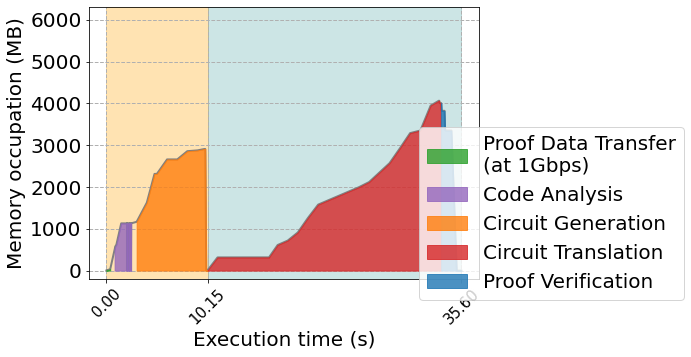

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


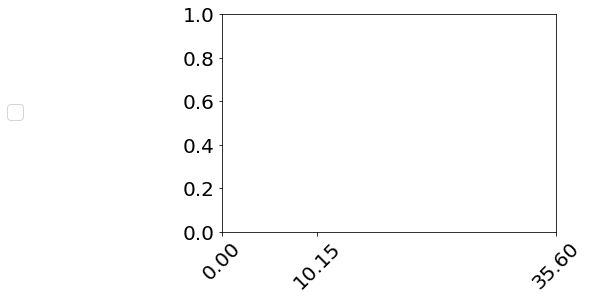

([<matplotlib.axis.XTick at 0x7f9344db8520>,
 [Text(0.0, 0, '0.00'),
  Text(35.604971072000005, 0, '35.60'),
  Text(10.152691072, 0, '10.15')])

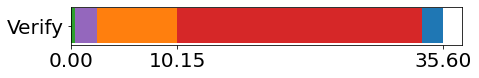

In [11]:
transfer_time = (134*8)/1000000000

circuit = "HTTP_Merkle"
df2 = pandas.read_json(path+"/verify_"+circuit+"_output.json").round(5)
df2.columns = ['output', 'timestamp', 'cpu_timestamp']
old_duration = df2['timestamp'][1]
df2['timestamp'] = df2['timestamp'] - old_duration + transfer_time
df2['timestamp'][0] = 0
timestamps=df2['timestamp']
df2 = df2.iloc[:, [1,0,2]]
df2.set_index('timestamp')
colorlist = ['C4', 'C8', 'C2',  'C6', 'C0', 'C5']

print(timestamps[df2['output'].str.contains('\[1st Phase\]')].values[0])
timestamps=df2['timestamp']
highlights = [timestamps[df2['output'].str.contains('Verification starts now')].values[0], 
              timestamps[df2['output'].str.contains('\[1st Phase\]')].values[0], 
              timestamps[df2['output'].str.contains('\[2nd Phase\]')].values[0], 
              timestamps[df2['output'].str.contains('Reset time counters for profiling\n')].values[0], 
              timestamps[df2['output'].str.contains('Reading verification key \(preprocessed\)')].values[0], 
              timestamps.tail(1).values[0]]
highlights_verify=highlights
print(highlights)
df = pandas.read_json(path+"/verify_"+circuit+"_memory.json").round(5)
df.columns = ['memory', 'timestamp', 'cpu_timestamp']
df = df.iloc[:, [1,0,2]]
df.set_index('timestamp')
df2 = df2.round(2)
df = df.round(2)

df = df.merge(df2, how = 'outer')
df = df.sort_values('timestamp').reset_index(drop=True)
df['memory'] = df['memory'].fillna(value=0)
labels = ["Proof Data Transfer\n(at 1Gbps)", "Code Analysis", "Circuit Generation", "Circuit Translation", "Proof Verification"]



plt.figure(figsize=(7, 5))
plt.plot(df['timestamp'], df['memory'], linewidth=2, zorder=3, color='grey')
plt.ylim([-200, 6300])
ticks=[highlights[0], highlights[-1]]
thr = 3
for tick in highlights:
	if not any(abs(tick - num) <= thr for num in ticks):
	    ticks.append(tick)

plt.xlabel("Execution time (s)")
plt.ylabel("Memory occupation (MB)")
plt.yticks(numpy.arange(0, 7000, step=1000))
plt.xticks(ticks, rotation = 45, fontsize=15)

for (i,instant) in enumerate(highlights[:-1]):
	index = df['timestamp'].between(highlights[i], highlights[i+1], inclusive="both")
	plt.fill_between(df['timestamp'][index], df['memory'][index], label=labels[i], alpha=0.8, zorder=4+i, color=colorlist[i])
plt.legend(loc='center right', bbox_to_anchor=(1.55, 0.24)).set_zorder(100)
plt.grid(linestyle = '--', linewidth = 1, zorder=20)
plt.axvspan(0, highlights[3], alpha=0.3, color='orange', zorder=1)
plt.axvspan(highlights[3], highlights[-1], alpha=0.2, color='teal', zorder=1)
#plt.title("Verify", fontsize=25)
plt.savefig("stringverifymemlegend.pdf", format="pdf", bbox_inches="tight")
plt.show()



for (i, instant) in enumerate(highlights[:-1]):
    ax_bar.barh("Verify", highlights[i+1]-highlights[i], height=0.3, left = (highlights[i]), label=labels[i], color=colorlist[i])
plt.legend(loc='center left', bbox_to_anchor=(-0.67,0.55))
plt.xticks(ticks, rotation=45, zorder = 100)
#plt.ylim(0,1)
plt.savefig("stringverifybarlegend.pdf", format="pdf", bbox_inches="tight")

plt.show()

plt.figure(figsize=(7, 0.7))
for (i, instant) in enumerate(highlights[:-1]):
    plt.barh("Verify", highlights[i+1]-highlights[i], height=0.3, left = (highlights[i]), label=labels[i], color=colorlist[i])
plt.xticks(ticks, rotation=0)
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 2.3))

verify [0.0, 0.392371072, 2.4920210719999996, 10.152691072, 33.532541072, 35.604971072000005]
prove [ 0.       2.76414 10.08479 10.85893 37.04326 38.80864 50.34275 51.98117]


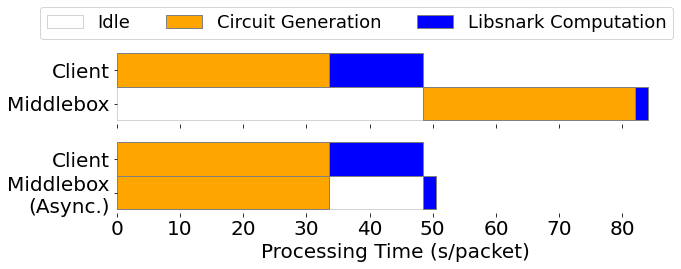

In [87]:
import numpy as np
matplotlib.rcParams.update({'font.size': 20})

#print(highlights_prove[-1])
print("verify", highlights_verify)

print("prove", highlights_prove)

cases=("Verify-Async", 'Verify','Prove')
'''ops={
    "Idle": np.array([70, 0, 0]),
    "Libsnark Operations": np.array([(highlights_verify[-1]-highlights_verify[4]), (highlights_verify[-1]-highlights_verify[4]), (highlights_prove[-1]-highlights_prove[5])]), 
    "Circuit/Input Generation": np.array([highlights_verify[4], highlights_verify[4], highlights_prove[5]-highlights_prove[1]]),

}'''


fig_bar, ax_bar=plt.subplots(2,1, figsize=(10,3), sharex=True)
#ax_bar[0].axis('off')
event = ["Middlebox", "Client"]
event2 = ["Middlebox\n(Async.)", "Client"]

shift=highlights_prove[4]-highlights_verify[4]
begin = np.array([highlights_prove[0], 
                  highlights_prove[0]])
begin2 = np.array([highlights_verify[0], 
                  highlights_prove[0]])

end =   np.array([highlights_prove[-1]-shift,
                  highlights_prove[0]])

end2 = np.array([highlights_prove[-1]-shift, 
                  highlights_prove[0]])
ax_bar[0].barh(range(len(begin)), end-begin, label="Idle", align='center', height=1.0, left=begin, edgecolor="lightgrey", color='white')
ax_bar[1].barh(range(len(begin2)), end2-begin2, label="Idle", align='center', height=1.0, left=begin2, edgecolor="lightgrey", color='white')

begin = np.array([highlights_prove[-1]-shift, 
                  highlights_prove[0]])
end =   np.array([highlights_prove[-1]-shift+highlights_verify[4],
                  highlights_verify[4]])
begin2 = np.array([highlights_verify[0], 
                  highlights_prove[0]])
end2 =   np.array([highlights_verify[4], 
                  highlights_verify[4]])
ax_bar[0].barh(range(len(begin)), end-begin, label="Circuit Generation", align='center', height=1.0, left=begin, edgecolor="grey", color='orange')
ax_bar[1].barh(range(len(begin2)), end2-begin2, label="Circuit Generation", align='center', height=1.0, left=begin2, edgecolor="grey", color='orange')

begin = np.array([highlights_prove[-1]-shift+highlights_verify[4], 
                  highlights_verify[4]])
end =   np.array([highlights_prove[-1]-shift+highlights_verify[-1],
                  highlights_prove[-1]-shift])
begin2 = np.array([highlights_prove[-1]-shift, 
                  highlights_verify[4]])
end2 =   np.array([highlights_prove[-1]-shift+highlights_verify[-1]-highlights_verify[4], 
                  highlights_prove[-1]-shift])
ax_bar[0].barh(range(len(begin)), end-begin, label="Libsnark Computation", align='center', height=1.0, left=begin, edgecolor="grey", color='blue')
ax_bar[1].barh(range(len(begin2)), end2-begin2, label="Libsnark Computation", align='center', height=1.0, left=begin2, edgecolor="grey", color='blue')

plt.sca(ax_bar[0])
plt.box(False)
plt.yticks(range(len(begin)), event)
#ax_bar[0].yaxis.tick_right()
plt.sca(ax_bar[1])
plt.box(False)
plt.yticks(range(len(begin)), event2)
#ax_bar[1].yaxis.tick_right()


ax_bar[0].legend(loc='upper center',bbox_to_anchor=(0.43, 1.7),ncol=3, fontsize=18)
plt.xlabel("Processing Time (s/packet)")
plt.savefig("timesbarplot.pdf", format="pdf", bbox_inches="tight")


# Complexity over Policy Length - HTTP_String + HTTP_Merkle_Token

## Processing Functions

##### Dataframe Manipulation

In [40]:
def build_average(proc, circuit, path, url_range, run_range):
    times = pandas.DataFrame(url_range, columns = ['parameter'])
    for run in run_range:
        #print(run)
        run=str(run)
        new_times = []
        #num_gates=[]
        for i in url_range:   
            if circuit == 'Test_HTTP_Merkle':
                df = pandas.read_json(path+"run"+run+"/output/output_"+proc+"_"+circuit+str(i)+"_"+run+".json").round(5)
                df.columns = ['output', 'timestamp', 'cpu_timestamp']
                if proc == 'java':
                    df['timestamp'] = (df['timestamp']-df['timestamp'][2])
                    df = df[2:]
                    #print(df.to_string())
            else:
                df = pandas.read_json(path+"run"+run+"/output_"+proc+"_"+circuit+"_"+str(i)+"_"+run+".json").round(5)
                df.columns = ['output', 'timestamp', 'cpu_timestamp']
            if proc == 'libsnark_setup':
                df = df[:-2]
            df.columns = ['output', 'timestamp', 'cpu_timestamp']
            #num_gates += [df['output'][df['output'].str.contains('\t Total Number of Constraints')].values[0].split()[-1]]
            new_times += [df['timestamp'].tail(1).values[0]]
        times[run] = new_times
    #print(times.iloc[:,1:])
    times['avg'] = times.iloc[:,1:].mean(axis=1)
    return(times)


In [41]:
def build_average_cpu(proc, circuit, path, url_range, run_range):
    times = pandas.DataFrame(url_range, columns = ['parameter'])
    for run in run_range:
        #print(run)
        run=str(run)
        new_times = []
        #num_gates=[]
        for i in url_range:   
            if circuit == 'Test_HTTP_Merkle':
                df = pandas.read_json(path+"run"+run+"/output/output_"+proc+"_"+circuit+str(i)+"_"+run+".json").round(5)
                df.columns = ['output', 'timestamp', 'cpu_timestamp']
                #if proc == 'java':
                #    df['timestamp'] = (df['timestamp']-df['timestamp'][2])
                #    df = df[2:]
                    #print(df.to_string())
            else:
                df = pandas.read_json(path+"run"+run+"/output_"+proc+"_"+circuit+"_"+str(i)+"_"+run+".json").round(5)
                df.columns = ['output', 'timestamp', 'cpu_timestamp']
            if proc == 'libsnark_setup':
                df = df[:-2]
            df.columns = ['output', 'timestamp', 'cpu_timestamp']
            #num_gates += [df['output'][df['output'].str.contains('\t Total Number of Constraints')].values[0].split()[-1]]
            new_times += [df['cpu_timestamp'].tail(1).values[0]]
        times[run] = new_times
    #print(times.iloc[:,1:])
    times['avg'] = times.iloc[:,1:].mean(axis=1)
    return(times)

##### Lin Reg for Time Complexity

In [42]:
from sklearn.linear_model import LinearRegression

def four_plots_with_prediction(circuit, path, url_range, run_range, fig_times, axs_time, tag, dot, linecolor, pmarker):
    #plt.style.use('default')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)
    fig_times.suptitle("", fontsize=13)

    #fig_times = plt.figure()
    ytitle_times = "Execution Time (s)"
    xtitle = "Policy Size (bytes)"
    #print(times)

    times = build_average("libsnark_verify", circuit, path, url_range, run_range)
    X_range = []
    y = []
    for i in run_range:
        X_range += url_range
        #print(times[str(i)].values[0])
        y+=times[str(i)].tolist()
        axs_time.plot(times['parameter'], times[str(i)],linestyle='', marker=pmarker, linewidth=1, markersize=5, label='Samples '+tag if i == dot else None, zorder=100)
        axs_time.set_title('Proof Verification', fontsize = 14)
    #print(len(X_range))
    #print(len(y))
    plt.setp(axs_time, yticks=range(0, 250, 50), ylim=(0, 230), xlim=(0, max(url_range)+min(url_range)*2), xticks=[i for i in range(0, max(url_range)+min(url_range), min(url_range)*2)])
    X = numpy.array(X_range).reshape(-1, 1)
    model_time = LinearRegression()
    model_time.fit(X, y)
    print(model_time.coef_[0], model_time.intercept_)
    url_range_pred = [i for i in range(0, 2200, 5)]
    X_new = numpy.array(url_range_pred).reshape(-1, 1)
    predictions = model_time.predict(X_new)
    axs_time.plot(url_range_pred, predictions, color=linecolor, label='Regression '+tag, zorder=70)

    axs_time.grid(True, linestyle = '--', linewidth = 1, alpha=0.5)
        #ax.xaxis.set_minor_locator(AutoMinorLocator())
    axs_time.set_xlabel(xtitle, fontsize=13)
    axs_time.set_ylabel(ytitle_times, fontsize=13)
    axs_time.spines[:].set_visible(True)
    axs_time.legend()
    #plt.savefig(circuit+".pdf", format="pdf", bbox_inches="tight")





In [43]:
from scipy.optimize import curve_fit

def four_plots_with_poly_prediction(circuit, path, url_range, run_range, fig_times, axs_time, tag, dot, linecolor, pmarker):
    #plt.style.use('default')
    def func(x, a, b, c, d):
        return a* x * numpy.sqrt(b*x + d) + c
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)
    fig_times.suptitle("", fontsize=13)

    #fig_times = plt.figure()
    ytitle_times = "Verification Time (s)"
    xtitle = "Max Payload Size (bytes)"
    #print(times)
    times = build_average("libsnark_verify", circuit, path, url_range, run_range)
    X_range = []
    y = []
    for i in run_range:
        X_range += url_range
        #print(times[str(i)].values[0])
        y+=times[str(i)].tolist()
        axs_time.plot(times['parameter'], times[str(i)],linestyle='', marker=pmarker, linewidth=1, markersize=5, label='Samples '+tag if i == dot else None, zorder=100)
        axs_time.set_title('Verify', fontsize = 14)
    #print(len(X_range))
    #print(len(y))
    plt.setp(axs_time, yticks=range(0, 350, 20), ylim=(0, 150), xlim=(0, max(url_range)+min(url_range)*2), xticks=[i for i in range(0, max(url_range)+min(url_range), min(url_range)*2)])
    popt, pcov = curve_fit(func, times['parameter'], times['avg'])
    url_range_pred = [i for i in range(0, 2200, 5)]
    X_new = numpy.array(url_range_pred).reshape(-1, 1)

    axs_time.plot(X_new, func(X_new, *popt), color=linecolor, label='Regression '+tag, zorder=70)

    axs_time.grid(True, linestyle = '--', linewidth = 1, alpha=0.5)
        #ax.xaxis.set_minor_locator(AutoMinorLocator())
    axs_time.set_xlabel(xtitle, fontsize=13)
    axs_time.set_ylabel(ytitle_times, fontsize=13)
    axs_time.spines[:].set_visible(True)
    axs_time.legend()
    plt.savefig(circuit+"paper.pdf", format="pdf", bbox_inches="tight")


##### Linear Regression for Space Complexity

In [5]:
def build_linreg_space(y, y_merkle, X_original, param_range, xlabel, ylabel, title, xticks, yticks):
    from sklearn.linear_model import LinearRegression
    from scipy.optimize import curve_fit
    def func(x, a, b, c, d):
        return a* x * numpy.sqrt(b*x + d) + c

    #X = numpy.array(url_range).reshape(-1, 1)
    X=numpy.array(X_original).reshape(-1,1)
    print(X)

    model = LinearRegression()
    model.fit(X, y)
    print(model.coef_[0], model.intercept_)

    prediction_X_orig = [i for i in param_range]
    X_new = numpy.array(prediction_X_orig).reshape(-1, 1)
    predictions = model.predict(X_new)

    plt.figure(figsize=(5, 5))
    plt.scatter(X_original, y, label='Samples (Str)', s=100, zorder=100)
    plt.plot(X_new, predictions, color='paleturquoise', label='Regression (Str)')

    plt.scatter(X_original, y_merkle, label='Samples (Hdr)', s=100, zorder=99, marker='X', color='orange')
    popt, pcov = curve_fit(func, X_original, y_merkle)
    X_new = numpy.array([i for i in param_range]).reshape(-1, 1)
    plt.plot(X_new, func(X_new, *popt), color='mediumpurple', label='Regression (Hdr)', zorder=70)

    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.title(title, fontsize=15)
    plt.legend(fontsize=15)
    plt.grid(True, linestyle = '--', linewidth = 1, alpha=0.5)
    plt.xticks(xticks, fontsize=13)
    plt.yticks(yticks, fontsize=13)

    plt.savefig(ylabel+".pdf", format="pdf", bbox_inches="tight")

    plt.show()

## HTTP_String

##### Time

0.019836099704142005 16.41337634615386


C:\Users\otti9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\otti9\AppData\Local\Temp\ipykernel_17044\1597820153.py:6: RuntimeWarning: invalid value encountered in sqrt
  return a* x * numpy.sqrt(b*x + d) + c


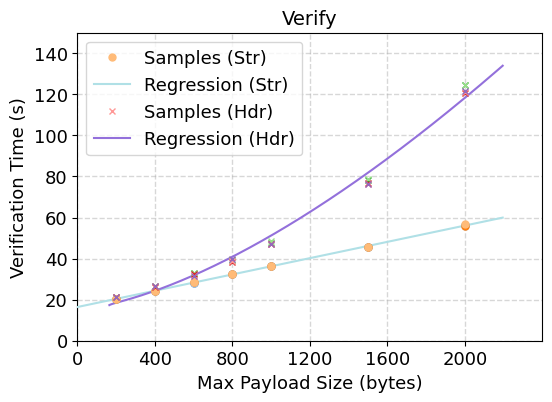

In [45]:
pk_size = []
circuit='HTTP_String'
url_range = [200, 400, 600, 800, 1000, 1500, 2000]
path = "outputs/Test_HTTP_String/"
#four_plots(circuit, path, url_range, range(7,12))
fig_times, axs_time = plt.subplots(1,1, figsize=(6, 4))
four_plots_with_prediction(circuit, path, url_range, range(7,11), fig_times, axs_time, '(Str)', 10, 'powderblue', 'o')
four_plots_with_poly_prediction('Test_HTTP_Merkle_Token', 'outputs/Test_HTTP_Merkle_Token/', url_range, range(7,12), fig_times, axs_time, '(Hdr)', 10, 'mediumpurple', 'x')

##### Space - LinReg

[1562414, 1707474, 1864022, 2009077, 2165621, 2539752, 2913878] [1549597, 1690853, 1843597, 1984853, 2137597, 2502225, 2866853]
[[ 200]
 [ 400]
 [ 600]
 [ 800]
 [1000]
 [1500]
 [2000]]
733.3345798816569 1401271.4615384615


C:\Users\otti9\AppData\Local\Temp\ipykernel_1272\723024954.py:5: RuntimeWarning: invalid value encountered in sqrt
  return a* x * numpy.sqrt(b*x + d) + c


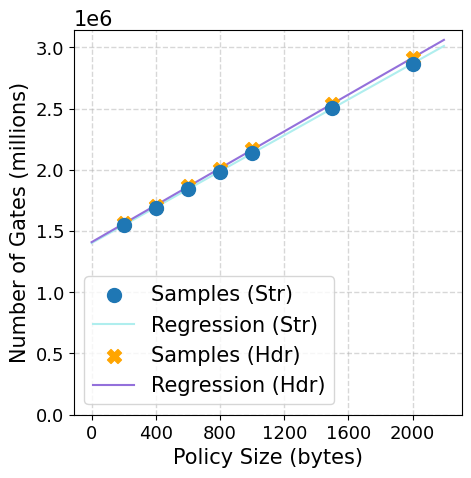

[[ 200]
 [ 400]
 [ 600]
 [ 800]
 [1000]
 [1500]
 [2000]]
0.4171621588461539 670.0782605000002


C:\Users\otti9\AppData\Local\Temp\ipykernel_1272\723024954.py:5: RuntimeWarning: invalid value encountered in sqrt
  return a* x * numpy.sqrt(b*x + d) + c


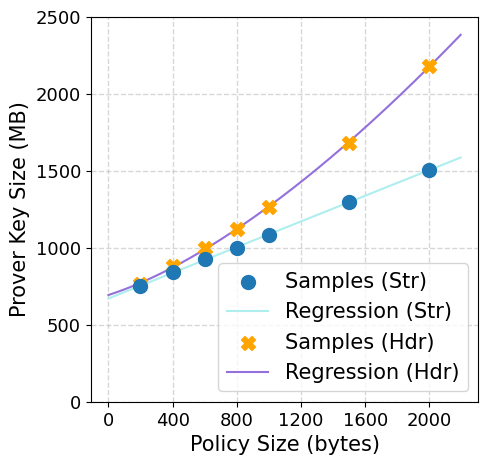

In [33]:
url_range = [200, 400, 600, 800, 1000, 1500, 2000]
key_size = []
for i in url_range:
    key_size += [pandas.read_json("outputs/Test_HTTP_String/run7/output_libsnark_setup_HTTP_String_"+str(i)+"_7.json").round(5)[1].tail(2).values[0]/1000000]
n_gates = []
for i in url_range:
    gates_frame = pandas.read_json("outputs/Test_HTTP_String/run7/output_java_HTTP_String_"+str(i)+"_7.json").round(5)
    gates_frame.columns = ['output', 'timestamp', 'cpu_timestamp']
    n_gates += [int(gates_frame['output'][gates_frame['output'].str.contains('\t Total Number of Constraints')].values[0].split()[-1])]
n_gates_token = []
for i in url_range:
    gates_frame = pandas.read_json("outputs/Test_HTTP_Merkle_Token/run7/output_java_Test_HTTP_Merkle_Token_"+str(i)+"_7.json").round(5)
    gates_frame.columns = ['output', 'timestamp', 'cpu_timestamp']
    n_gates_token += [int(gates_frame['output'][gates_frame['output'].str.contains('\t Total Number of Constraints')].values[0].split()[-1])]
key_size_token = []
for i in url_range:
    key_size_token += [pandas.read_json("outputs/Test_HTTP_Merkle_Token/run7/output_libsnark_setup_Test_HTTP_Merkle_Token_"+str(i)+"_7.json").round(5)[1].tail(2).values[0]/1000000]
print(n_gates_token, n_gates)
build_linreg_space(n_gates, n_gates_token, url_range, range(0, 2200, 5), "Policy Size (bytes)", "Number of Gates (millions)", "", range(0, 2200, 400), range(0, 3500000, 500000))
build_linreg_space(key_size, key_size_token, url_range, range(0, 2200, 5), "Policy Size (bytes)", "Prover Key Size (MB)", "", range(0, 2200, 400), range(0, 3000, 500))

## HTTP_Merkle

##### LinReg for Time

In [34]:
from sklearn.linear_model import LinearRegression

def four_plots_with_prediction(circuit, path, url_range, run_range):
    fig_times, axs_time = plt.subplots(2, 2, figsize=(10, 8))
    plt.style.use('default')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)
    fig_times.suptitle("", fontsize=20)

    #fig_times = plt.figure()
    ytitle_times = "Execution Time (s)"
    xtitle = "Tree Size (Number of Leaves)"
    #print(times)
    
    times = build_average("java", circuit, path, url_range, run_range)

    X_range = []
    y = []
    for i in run_range:
        X_range += url_range
        #print(times[str(i)].values[0])
        y+=times[str(i)].tolist()
        axs_time[0][0].plot(numpy.power(2, times['parameter']), times[str(i)],linestyle='', marker='o', linewidth=1, markersize=5, label='Samples' if i == 8 else None, zorder=100)
        axs_time[0][0].set_title('Circuit Generation', fontsize = 14)
    #print(len(X_range))
    #print(len(y))
    X = numpy.array(X_range).reshape(-1, 1)
    model_time = LinearRegression()
    model_time.fit(X, y)
    print(model_time.coef_[0], model_time.intercept_)
    url_range_pred = [i for i in range(0, 30, 1)]
    X_new = numpy.array(url_range_pred).reshape(-1, 1)
    predictions = model_time.predict(X_new)
    axs_time[0][0].plot(numpy.power(2, url_range_pred), predictions, color='powderblue', label='Regression', zorder=70)
    
    times = build_average("libsnark_setup", circuit, path, url_range, run_range)
    X_range = []
    y = []
    for i in run_range:
        X_range += url_range
        #print(times[str(i)].values[0])
        y+=times[str(i)].tolist()
        axs_time[0][1].plot(numpy.power(2, times['parameter']), times[str(i)],linestyle='', marker='o', linewidth=1, markersize=5, label='Samples' if i == 8 else None, zorder=100)
        axs_time[0][1].set_title('Setup Phase', fontsize = 14)
        axs_time[0][1].set_xscale('log')
    #print(len(X_range))
    #print(len(y))
    X = numpy.array(X_range).reshape(-1, 1)
    model_time = LinearRegression()
    model_time.fit(X, y)
    print(model_time.coef_[0], model_time.intercept_)
    url_range_pred = [i for i in range(0, 30, 1)]
    X_new = numpy.array(url_range_pred).reshape(-1, 1)
    predictions = model_time.predict(X_new)
    axs_time[0][1].plot(numpy.power(2,url_range_pred), predictions, color='powderblue', label='Regression', zorder=70)


    
    times = build_average("libsnark_prove", circuit, path, url_range, run_range)
    X_range = []
    y = []
    for i in run_range:
        X_range += url_range
        #print(times[str(i)].values[0])
        y+=times[str(i)].tolist()
        axs_time[1][0].plot(numpy.power(2, times['parameter']), times[str(i)],linestyle='', marker='o', linewidth=1, markersize=5, label='Samples' if i == 8 else None, zorder=100)
        axs_time[1][0].set_title('Proof Generation', fontsize = 14)
    #print(len(X_range))
    #print(len(y))
    plt.setp(axs_time, ylim=(0, 330))#xlim=(0, 2**30))#, xticks=[i for i in range(0, max(url_range)+min(url_range), min(url_range)*2)])
    X = numpy.array(X_range).reshape(-1, 1)
    model_time = LinearRegression()
    model_time.fit(X, y)
    print(model_time.coef_[0], model_time.intercept_)
    url_range_pred = [i for i in range(0, 30, 1)]
    X_new = numpy.array(url_range_pred).reshape(-1, 1)
    predictions = model_time.predict(X_new)
    axs_time[1][0].plot(numpy.power(2, url_range_pred), predictions, color='powderblue', label='Regression', zorder=70)

    times = build_average("libsnark_verify", circuit, path, url_range, run_range)
    X_range = []
    y = []
    for i in run_range:
        X_range += url_range
        #print(times[str(i)].values[0])
        y+=times[str(i)].tolist()
        axs_time[1][1].plot(numpy.power(2, times['parameter']), times[str(i)],linestyle='', marker='o', linewidth=1, markersize=5, label='Samples' if i == 8 else None, zorder=100)
        axs_time[1][1].set_title('Proof Verification', fontsize = 14)
    #print(len(X_range))
    #print(len(y))
    X = numpy.array(X_range).reshape(-1, 1)
    model_time = LinearRegression()
    model_time.fit(X, y)
    print(model_time.coef_[0], model_time.intercept_)
    url_range_pred = [i for i in range(0, 30, 1)]
    X_new = numpy.array(url_range_pred).reshape(-1, 1)
    predictions = model_time.predict(X_new)
    axs_time[1][1].plot(numpy.power(2, url_range_pred), predictions, color='powderblue', label='Regression', zorder=70)

    for ax in axs_time.flat:
        ax.grid(True, linestyle = '--', linewidth = 1, alpha=0.5)
        #ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.set_xlabel(xtitle, fontsize=13)
        ax.set_ylabel(ytitle_times, fontsize=13)
        ax.spines[:].set_visible(True)
        ax.legend()
        ax.set_xscale('log', base=2)
    #axs_time[0][0].set_ylabel("CPU Execution Time (s)", fontsize=13)
    plt.savefig(circuit+".pdf", format="pdf", bbox_inches="tight")


0.012054091666666685 10.650859041666665
0.023125766666666686 103.10772316666666
0.018126758333333277 130.480911875
0.00440499166666665 27.443242041666664


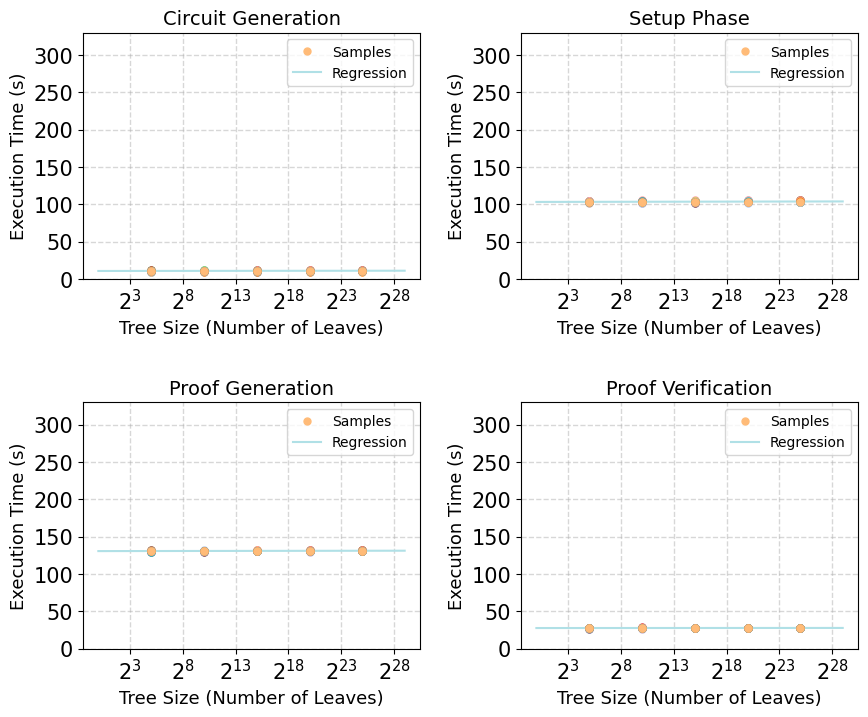

In [ ]:
pk_size = []
circuit='Test_HTTP_Merkle'
url_range = [5, 10, 15, 20, 25]
path = "outputs/Test_HTTP_Merkle/"
four_plots_with_prediction(circuit, path, url_range, range(5,29))

##### LinReg for Space

In [45]:
def build_linreg_space(y, X_original, param_range, xlabel, ylabel, title, xticks, yticks):
    from sklearn.linear_model import LinearRegression
    from scipy.optimize import curve_fit
    def func(x, a, b, c, d):
        return a* x * numpy.sqrt(b*x + d) + c

    #X = numpy.array(url_range).reshape(-1, 1)
    X=numpy.array(X_original).reshape(-1,1)
    print(X)

    model = LinearRegression()
    model.fit(X, y)
    print(model.coef_[0], model.intercept_)

    prediction_X_orig = [i for i in param_range]
    X_new = numpy.array(prediction_X_orig).reshape(-1, 1)
    predictions = model.predict(X_new)

    plt.figure(figsize=(5, 5))
    plt.scatter(X_original, y, label='Samples', s=100, zorder=100)
    plt.plot(X_new, predictions, color='paleturquoise', label='Regression')
    #popt, pcov = curve_fit(func, X_original, y_merkle)
    X_new = numpy.array([i for i in param_range]).reshape(-1, 1)

    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.title(title, fontsize=15)
    plt.legend(fontsize=15)
    plt.grid(True, linestyle = '--', linewidth = 1, alpha=0.5)
    plt.xticks(xticks, fontsize=13)
    plt.yticks(yticks, fontsize=13)

    plt.savefig(ylabel+".pdf", format="pdf", bbox_inches="tight")

    plt.show()

[[ 5]
 [10]
 [15]
 [20]
 [25]]
242.0 1781819.0


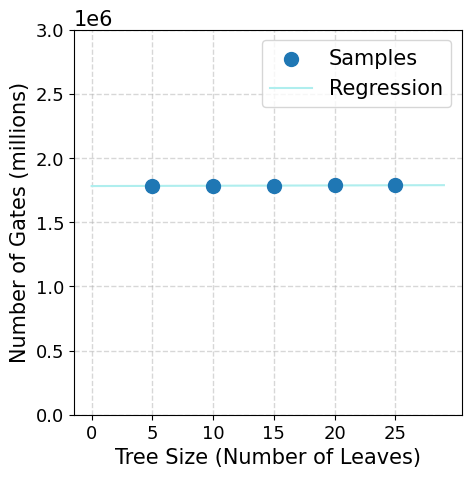

[[ 5]
 [10]
 [15]
 [20]
 [25]]
0.3287635599999953 891.1030598000001


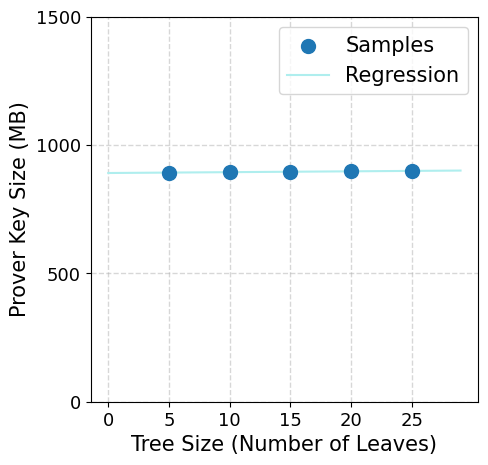

In [46]:
tree_range = [i for i in range(5, 30, 5)]
key_size = []
for i in tree_range:
    key_size += [pandas.read_json("outputs/Test_HTTP_Merkle/run7/output/output_libsnark_setup_Test_HTTP_Merkle"+str(i)+"_7.json").round(5)[1].tail(2).values[0]/1000000]
#print("K:",key_size)
n_gates = []

for i in tree_range:
    gates_frame = pandas.read_json("outputs/Test_HTTP_Merkle/run7/output/output_java_Test_HTTP_Merkle"+str(i)+"_7.json").round(5)
    gates_frame.columns = ['output', 'timestamp', 'cpu_timestamp']
    n_gates += [int(gates_frame['output'][gates_frame['output'].str.contains('\t Total Number of Constraints')].values[0].split()[-1])]
#print("G:",n_gates)

build_linreg_space(n_gates, tree_range, range(0, 30, 1), "Tree Size (Number of Leaves)", "Number of Gates (millions)", "", range(0, 30, 5), range(0, 3500000, 500000))
build_linreg_space(key_size, tree_range, range(0, 30, 1), "Tree Size (Number of Leaves)", "Prover Key Size (MB)", "", range(0, 30, 5), range(0, 2000, 500))

# Radar Chart: Comparison

#### Plotting subroutines

In [ ]:
#import matplotlib.pyplot as plt
from math import pi
import numpy as np
import pandas as pd

class Radar(object):

    def __init__(self, fig, titles, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.95, 0.95]

        self.n = len(titles)
        self.angles = np.arange(90, 90+360, 360.0/self.n)
        self.axes = [fig.add_axes(rect, projection="polar", label="axes%d" % i, zorder=20+i) 
                         for i in range(self.n)]

        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=titles, fontsize=14, zorder=9)
        for ax in self.axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.set_rgrids(range(1, 6), angle=angle, labels=label, alpha = 1, zorder=10, fontsize=14)
            ax.spines["polar"].set_visible(False)
            ax.fill()
            ax.set_ylim(0, 6)

    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = (np.array(values) - np.array(minmax[0]))/((np.array(minmax[1])-np.array(minmax[0]))/5)
        print(values)
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)
        
        self.ax.fill(angle, values, alpha=0.4, zorder=kw['zorder'], color=kw['color'])


#### Actual Code

PK [886.897549, 892.435107, 939.801865]
MEM [6124.7447, 6173.58131, 6456.832]
TIME [142.1866, 146.45313, 148.91762]
[142.1866, 886.897549, 6124.7447]
[3.43732    1.34487745 1.247447  ]
[4.290626   1.62175535 1.7358131 ]
[4.783524   3.99009325 4.56832   ]


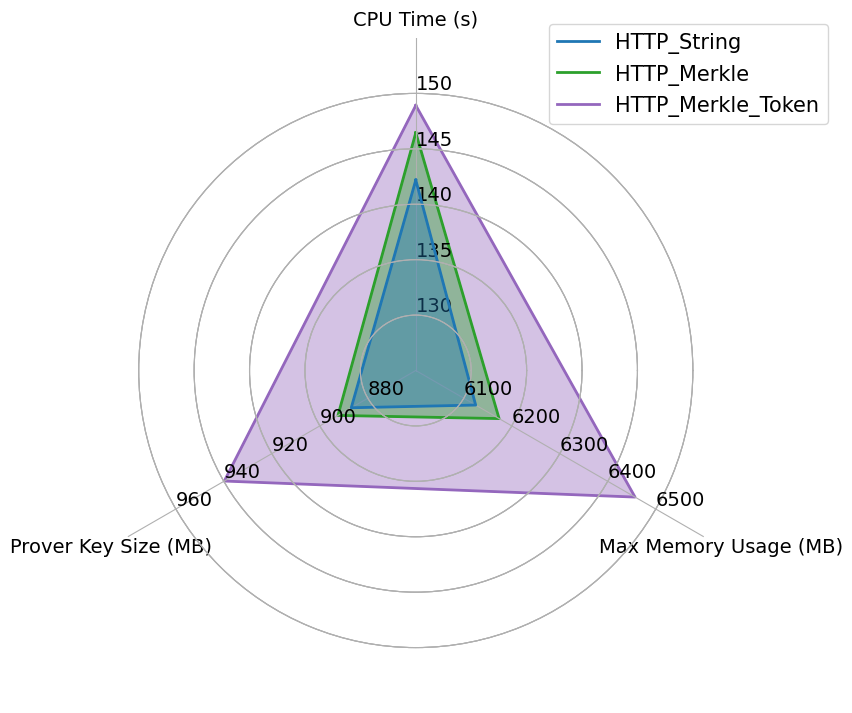

In [ ]:
pk_size = []
pk_size += [pd.read_json("outputs/full_simulations/HTTP_String/run4/setup_HTTP_String_output.json").round(5)[1].tail(2).values[0]/1000000, 
            pd.read_json("outputs/full_simulations/HTTP_Merkle/run4/setup_HTTP_Merkle_output.json").round(5)[1].tail(2).values[0]/1000000, 
            pandas.read_json("outputs/full_simulations/HTTP_Merkle_Token/run4/setup_HTTP_Merkle_Token_output.json").round(5)[1].tail(2).values[0]/1000000]
max_mem = []
max_mem +=[max(pd.read_json("outputs/full_simulations/HTTP_String/run4/setup_HTTP_String_memory.json").round(5)[0]), 
           max(pd.read_json("outputs/full_simulations/HTTP_Merkle/run4/setup_HTTP_Merkle_memory.json").round(5)[0]), 
           max(pd.read_json("outputs/full_simulations/HTTP_Merkle_Token/run4/setup_HTTP_Merkle_Token_memory.json").round(5)[0])]
exec_time = []
exec_time += [pd.read_json("outputs/full_simulations/HTTP_String/run4/prove_HTTP_String_output.json").round(5)[1].tail(1).values[0], 
              pd.read_json("outputs/full_simulations/HTTP_Merkle/run4/prove_HTTP_Merkle_output.json").round(5)[1].tail(1).values[0], 
              pd.read_json("outputs/full_simulations/HTTP_Merkle_Token/run4/prove_HTTP_Merkle_Token_output.json").round(5)[1].tail(1).values[0]]
print("PK",pk_size)
print("MEM",max_mem)
print("TIME", exec_time)
#merkle_data = []
#merkle_token_data = []

fig = plt.figure(figsize=(7, 7))

titles = list(("CPU Time (s)", "Prover Key Size (MB)", "Max Memory Usage (MB)"))

labels = []




minmax = [[125, 860, 6000],[150, 960, 6500],[5, 20, 100]]
for i in range(3):
    labels += [[n+minmax[2][i] for n in range(minmax[0][i], minmax[1][i], minmax[2][i])]]
#print(exec_time, pk_size, max_memory)
st = [exec_time[0], pk_size[0], max_mem[0]]
me = [exec_time[1], pk_size[1], max_mem[1]]
mt = [exec_time[2], pk_size[2], max_mem[2]]

print(st)
radar = Radar(fig, titles, labels)
radar.plot(st,"-", lw=2, color='C0', alpha=1, label="HTTP_String", zorder = 2)
radar.plot(me,"-", lw=2, color='C2', alpha=1, label="HTTP_Merkle", zorder = 1)
radar.plot(mt,"-", lw=2, color='C4', alpha=1, label="HTTP_Merkle_Token", zorder = 0)

#radar.ax.spines['polar'].set_visible(False)

#radar.plot([3, 4, 3, 4, 2], "-", lw=2, color="g", alpha=0.4, label="third")
radar.ax.legend(fontsize=15, loc=(0.7, 0.87))
plt.savefig("radarversus.pdf", format="pdf", bbox_inches="tight")